In [1]:
!pip install dipy nibabel fury

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 8.0 MB/s eta 0:00:00
  Created wheel for pygltflib: filename=pygltflib-1.16.1-py3-none-any.whl size=27085 sha256=be3e2d310a42f9314bca17c2a73d7051b376e407ca08618fc5f0f0c01d1960a6
  Stored in directory: /root/.cache/pip/wheels/9c/73/91/ae3a93bb6cc6dde662ed1d

In [2]:
# from tensorflow.keras.engine.input_layer import InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Input, Reshape, InputLayer, Dropout,LayerNormalization,Flatten, Add
from numpy import *
import numpy as np
from tensorflow.keras import backend as kf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from dipy.io.gradients import read_bvals_bvecs
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

In [3]:
class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv',
                         kernel_initializer='he_normal',
                         kernel_regularizer=tf.keras.regularizers.L1(0.02))
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.L1(0.02))
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1,  N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), attn.dtype)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [4]:
class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1',
                         kernel_initializer='he_normal',
                         kernel_regularizer=tf.keras.regularizers.L1(0.01))
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2',
                         kernel_initializer='he_normal',
                         kernel_regularizer=tf.keras.regularizers.L1(0.01))
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size[0],
                   window_size[0], W // window_size[1], window_size[1], C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size[0], window_size[1], C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size[0],
                   W // window_size[1], window_size[0], window_size[1], C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x

def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)

In [5]:
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim = 8, dim1=None, input_resolution=(8,8), num_heads=4, window_size=(4,4), shift_size=(0,0), mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.feedback_last = False
        if dim1==None:
          self.feedback_last = True
          dim1 = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if self.input_resolution[0] <= self.window_size[0]:
            self.shift_size = (0, self.shift_size[1])
            self.window_size = (self.input_resolution[0], self.window_size[1])

        if self.input_resolution[1] <= self.window_size[1]:
            self.shift_size = (self.shift_size[0], 0)
            self.window_size = (self.window_size[0],self.input_resolution[1])

        assert 0 <= self.shift_size[0] < self.window_size[0], "shift_size[0] must in 0-window_size[0]"
        assert 0 <= self.shift_size[1] < self.window_size[1], "shift_size[1] must in 0-window_size[1]"

        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size[0], self.window_size[1]), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim1 * mlp_ratio)
        self.mlp = Mlp(in_features=dim1, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

        self.proj = Dense(dim1, name=f'{self.prefix}/swin/proj',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.L1(0.05))

    def build(self, input_shape):
        if self.shift_size[0] > 0 or self.shift_size[1] > 0:
            if self.shift_size[0] > 0 and self.shift_size[1] > 0:
                H, W = self.input_resolution
                img_mask = np.zeros([1, H, W, 1])
                h_slices = (slice(0, -self.window_size[0]),
                            slice(-self.window_size[0], -self.shift_size[0]),
                            slice(-self.shift_size[0], None))
                w_slices = (slice(0, -self.window_size[1]),
                            slice(-self.window_size[1], -self.shift_size[1]),
                            slice(-self.shift_size[1], None))
                cnt = 0
                for h in h_slices:
                    for w in w_slices:
                        img_mask[:, h, w, :] = cnt
                        cnt += 1

            elif self.shift_size[0] > 0:
                H, W = self.input_resolution
                img_mask = np.zeros([1, H, W, 1])
                h_slices = (slice(0, -self.window_size[0]),
                            slice(-self.window_size[0], -self.shift_size[0]),
                            slice(-self.shift_size[0], None))
                cnt = 0
                for h in h_slices:
                    img_mask[:, h, :, :] = cnt
                    cnt += 1

            elif self.shift_size[1] > 0:
                H, W = self.input_resolution
                img_mask = np.zeros([1, H, W, 1])
                w_slices = (slice(0, -self.window_size[1]),
                            slice(-self.window_size[1], -self.shift_size[1]),
                            slice(-self.shift_size[1], None))
                cnt = 0
                for h in w_slices:
                    img_mask[:, :, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size[0] * self.window_size[1]])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        # print("Shape of x is ",x.shape)
        # print("x shape as list",x.get_shape().as_list())
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size[0] > 0 and self.shift_size[1] > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size[0], -self.shift_size[1]], axis=[1, 2])
        elif self.shift_size[0] > 0:
            shifted_x = tf.roll(x, shift=-self.shift_size[0], axis=1)
        elif self.shift_size[1] > 0:
            shifted_x = tf.roll(x, shift=-self.shift_size[1], axis=2)
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size[0] * self.window_size[1], C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        B_, L1, C1 = attn_windows.get_shape().as_list()
        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size[0], self.window_size[1], C1])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C1)

        # reverse cyclic shift
        if self.shift_size[0] > 0 and self.shift_size[1] > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size[0], self.shift_size[1]], axis=[1, 2])
        elif self.shift_size[0] > 0:
            x = tf.roll(shifted_x, shift=self.shift_size[0], axis=1)
        elif self.shift_size[1] > 0:
            x = tf.roll(shifted_x, shift=self.shift_size[1], axis=2)
        else:
            x = shifted_x

        x = tf.reshape(x, shape=[-1, H * W, C1])

        # FFN
        x = shortcut + self.drop_path(x)   ### First Feedback
        if self.feedback_last:
            x = x + self.drop_path(self.mlp(self.norm2(x))) ### Second Feedback
        else:
            x = self.drop_path(self.mlp(self.norm2(x)))  ### Second Feedback is removed

        return x

In [6]:
#Transformer_SW_Attention_HCP_Youth_Adult_data_upto10_100gradient
def conv_Attention41(input_size=(125, 100), d_h=128, learning_rate=1e-4, pretrained_weights=None):
  inputs = Input(input_size)


  dense_1 = Dense(d_h, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(inputs)
  # reshape= Reshape((64,1),input_shape= (64,))(dense_1)

  # conv0 = Conv1D(10, 1, activation='sigmoid', padding='same', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(inputs)

  WT_att = SwinTransformerBlock(dim=d_h, input_resolution=(16,8), num_heads=8, window_size=(8,8), shift_size=(7,7), mlp_ratio=1., prefix = 'swt',
                                drop=0.4, attn_drop=0.4, drop_path_prob=0.4)(dense_1)

  WT_att = SwinTransformerBlock(dim=d_h, input_resolution=(16,8), num_heads=8, window_size=(4,4), shift_size=(3,3), mlp_ratio=1., prefix = 'swt1',
                                drop=0.4, attn_drop=0.4, drop_path_prob=0.4)(WT_att)

  WT_att = SwinTransformerBlock(dim=d_h, input_resolution=(16,8), num_heads=8, window_size=(2,2), shift_size=(0,0), mlp_ratio=1., prefix = 'swt2',
                                 drop=0.4, attn_drop=0.4, drop_path_prob=0.4)(WT_att)

  WT_att = SwinTransformerBlock(dim=d_h, input_resolution=(16,8), num_heads=8, window_size=(4,4), shift_size=(3,3), mlp_ratio=1., prefix = 'swt3',
                                 drop=0.4, attn_drop=0.4, drop_path_prob=0.4)(WT_att)

  WT_att = SwinTransformerBlock(dim=d_h, input_resolution=(16,8), num_heads=8, window_size=(8,8), shift_size=(7,7), prefix = 'swt4',
                                drop=0.4, attn_drop=0.4, drop_path_prob=0.4)(WT_att)

  dense_1 = Dense(1, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(WT_att)
  reshape1= Reshape((128,),input_shape= (128,1))(dense_1)
  dense5_1 = Dense(125, activation='sigmoid', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(reshape1)

  dense_2 = Dense(1, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(WT_att)
  reshape2= Reshape((128,),input_shape= (128,1))(dense_2)
  dense5_2= Dense(125, activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(reshape2)

  dense_3 = Dense(1, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(WT_att)
  reshape3= Reshape((128,),input_shape= (128,1))(dense_3)
  dense5_3 = Dense(125, activation='sigmoid', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(reshape3)

  dense_4 = Dense(1, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(WT_att)
  reshape4= Reshape((128,),input_shape= (128,1))(dense_4)
  dense5_4 = Dense(125, activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(reshape4)

  dense_5 = Dense(1, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(WT_att)
  reshape5= Reshape((128,),input_shape= (128,1))(dense_5)
  dense5_5 = Dense(125, activation='tanh', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(reshape5)

  dense_6 = Dense(1, activation='gelu', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(WT_att)
  reshape6= Reshape((128,),input_shape= (128,1))(dense_6)
  dense5_6 = Dense(125, activation='sigmoid', kernel_initializer='glorot_uniform',kernel_regularizer='l1')(reshape6)

  model = Model(inputs=inputs, outputs=[dense5_1, dense5_2, dense5_3, dense5_4, dense5_5, dense5_6])

  def negexpsquare1(yTrue, yPred):
      return kf.mean(1 - kf.exp(-kf.pow(yTrue - yPred, 2) / 0.1))

  def rmse(yTrue, yPred):
      return kf.sqrt(kf.mean(10 * kf.pow(yTrue - yPred, 2)))

  def scaled_abs100(yTrue, yPred):
      return 1000 * 100 * kf.mean(kf.abs((yTrue - yPred)))

  def scaled_abs(yTrue, yPred):
      #wt = tf.constant([[1.0],[100.0],[100.0]])
      return 1000 * kf.mean(kf.abs((yTrue - yPred)))

  # model.compile(optimizer=Adam(lr=learning_rate), loss=['logcosh', 'binary_crossentropy'],
  #               metrics=['mean_squared_error'])
  model.compile(optimizer=Adam(learning_rate = learning_rate), loss=[scaled_abs, scaled_abs100, scaled_abs, scaled_abs100, scaled_abs100, scaled_abs],
                metrics=[rmse])

  model.summary()

  if (pretrained_weights):
      model.load_weights(pretrained_weights)

  return model

In [7]:
model = conv_Attention41(input_size = (128,100), d_h = 128, learning_rate = 1e-4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 100)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 128, 128)             12928     ['input_1[0][0]']             
                                                                                                  
 swin_transformer_block (Sw  (None, 128, 128)             113672    ['dense[0][0]']               
 inTransformerBlock)                                                                              
                                                                                                  
 swin_transformer_block_1 (  (None, 128, 128)             102280    ['swin_transformer_block[0

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 100)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 128, 128)             12928     ['input_1[0][0]']             
                                                                                                  
 swin_transformer_block (Sw  (None, 128, 128)             113672    ['dense[0][0]']               
 inTransformerBlock)                                                                              
                                                                                                  
 swin_transformer_block_1 (  (None, 128, 128)             102280    ['swin_transformer_block[0

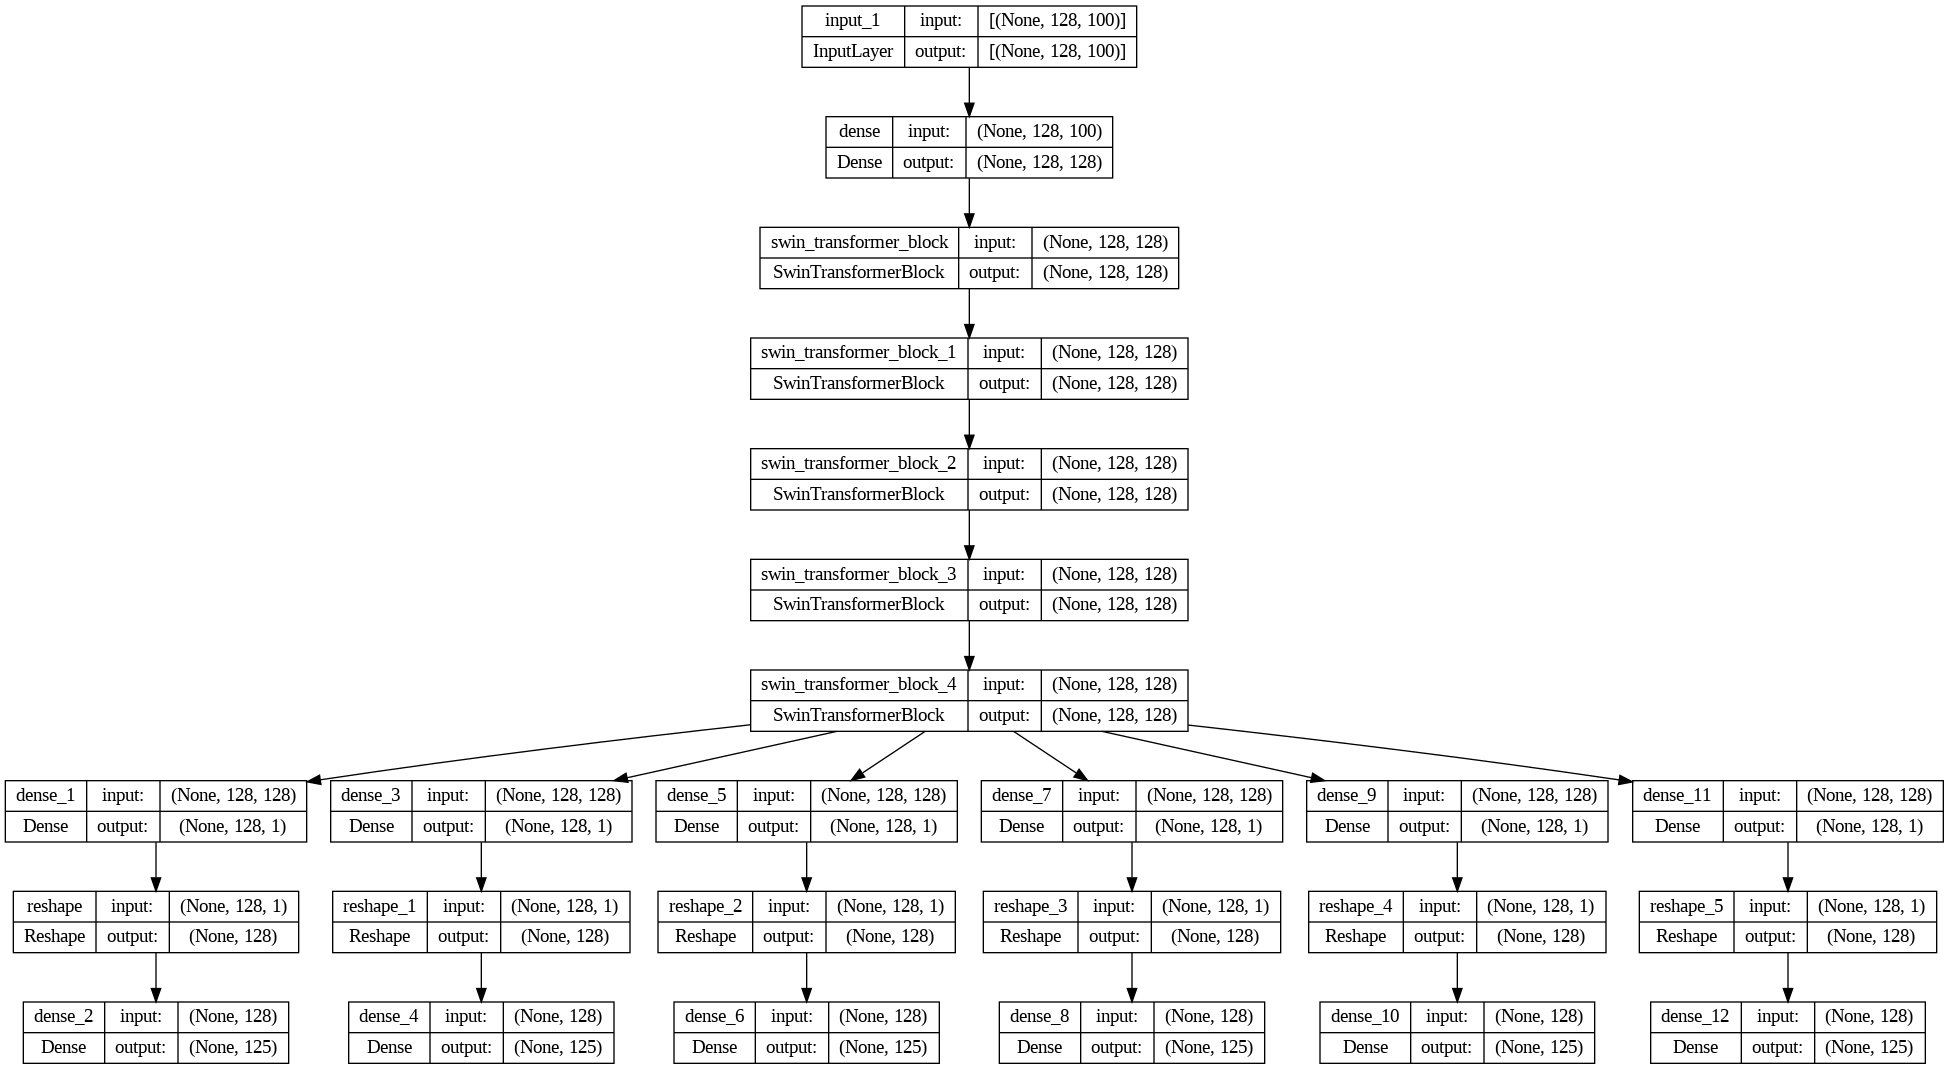

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


In [11]:
MegaTrainList = [["005_S_4707_M_68_AD_AD"]]


param_path=''
for iter in range(1):
  for TrainList in MegaTrainList:
    for diff_count in [21]:

      model = conv_Attention41(input_size=(128,100), d_h=128, learning_rate= 1e-4)

      X2_train = []
      y2_train= []

      X2_val = []
      y2_val = []


      for lst in TrainList:
        file_path_d2 = os.path.join(param_path,'Training_DTI_5x5x5_21_diff_AD/{}/training_data_{}_21_diff_bvals1000_AD.npz'.format(lst, lst))
        d2_data = np.load(file_path_d2)

        X2_train.append(d2_data['trainingdata'])
        y2_train.append(d2_data['traininglabel'])

      del d2_data

      X2_train = np.array(X2_train)
      X2_train_shape = X2_train.shape

      y2_train = np.array(y2_train)
      y2_train_shape = y2_train.shape

      X2_train = np.reshape(X2_train, (X2_train_shape[0]*X2_train_shape[1], X2_train_shape[2], X2_train_shape[3]))
      y2_train = np.reshape(y2_train, (y2_train_shape[0]*y2_train_shape[1], y2_train_shape[2], y2_train_shape[3]))

      ValidationList = MegaValidationList[iter]
      for lst in ValidationList:
        file_path_d2_val = os.path.join(param_path,'Training_DTI_5x5x5_21_diff_AD/{}/training_data_{}_21_diff_bvals1000_AD.npz'.format(lst, lst))
        d2_data_val = np.load(file_path_d2_val)

        X2_val.append(d2_data_val['trainingdata'])
        y2_val.append(d2_data_val['traininglabel'])

      del d2_data_val


      X2_val = np.array(X2_val)
      X2_val_shape = X2_val.shape

      y2_val = np.array(y2_val)
      y2_val_shape = y2_val.shape

      X2_val = np.reshape(X2_val, (X2_val_shape[0]*X2_val_shape[1], X2_val_shape[2], X2_val_shape[3]))
      y2_val = np.reshape(y2_val, (y2_val_shape[0]*y2_val_shape[1], y2_val_shape[2], y2_val_shape[3]))

      fullpath= ''
      fbval1 = os.path.join(fullpath,'100206_bvals1000_21_Diff.bval')
      fbvec1 = os.path.join(fullpath,'100206_bvecs1000__21_Diff.bval')

      bvals2, bvecs2 = read_bvals_bvecs(fbval1, fbvec1)

      diffusionGradientList= bvecs2
      noOfDiffusionComponent= bvecs2.shape[0]
      diffusionBVALSList= bvals2
      noOfBVALComponent= bvals2.shape[0]

      norm_of_diffusionGradientList = diffusionGradientList.__pow__(2).sum(1).__pow__(0.5)
      index_of_normalizing_bVecs = np.logical_and(diffusionBVALSList >=0,diffusionBVALSList <= 10)
      indexList_diffGrad_B0 = np.arange(0, noOfDiffusionComponent)[index_of_normalizing_bVecs]
      indexList_diffGrad = np.arange(0, noOfDiffusionComponent)[~index_of_normalizing_bVecs]
      indexList_Bvals_B0 = np.arange(0, noOfBVALComponent)[index_of_normalizing_bVecs]
      indexList_Bvals = np.arange(0, noOfBVALComponent)[~index_of_normalizing_bVecs]

      bvec2 = bvecs2[indexList_Bvals,:]
      bvec2= bvec2.transpose()
      XX2 = np.zeros((X2_train.shape[0], 128, 100))

      for i in range(X2_train.shape[0]):
        XX2[i, :X2_train.shape[1], :X2_train.shape[2]] = X2_train[i, :, :]
        XX2[i, X2_train.shape[1]:, :X2_train.shape[2]] = bvec2


      XX_train =  XX2  
      y_train =   y2_train     
      del X2_train,y2_train,XX2

      bvec2 = bvecs2[indexList_Bvals,:]
      bvec2= bvec2.transpose()
      XX2 = np.zeros((X2_val.shape[0], 128, 100))

      for i in range(X2_val.shape[0]):
        XX2[i, :X2_val.shape[1], :X2_val.shape[2]] = X2_val[i, :, :]
        XX2[i, X2_val.shape[1]:, :X2_val.shape[2]] = bvec2

      XX_val = XX2      # np.concatenate((XX6,XX7), axis=0,out=None,dtype=None,casting="same_kind")
      y_val =   y2_val        # np.concatenate((y6,y7), axis=0,out=None,dtype=None,casting="same_kind")
      del X2_val,y2_val,XX2



      
      param_path_2 = '/content/drive/MyDrive/Ananya_Singhal_2010110087/ISBI - ADNI/preprocessed_new_21_subs'

      modelpath = os.path.join(param_path_2,'Saved_Model_new_21subs/VER2_Patch5x5x5_ADNI_DATA_SWTransformer_5layer_Patch5x5x5_21_diff_additional_21subs_ver1.tf')

      if os.path.exists(modelpath):
        model.load_weights(filepath = modelpath)

      history = model.fit(batch_size = 2000, x = XX_train, y = [y_train[:,:,0], y_train[:,:,1], y_train[:,:,2], y_train[:,:,3], y_train[:,:,4], y_train[:,:,5]], epochs = 100, validation_data=(XX_val,[y_val[:,:,0], y_val[:,:,1], y_val[:,:,2], y_val[:,:,3], y_val[:,:,4], y_val[:,:,5]]))
      model.save(modelpath)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 100)]           0         []                            
                                                                                                  
 dense_13 (Dense)            (None, 128, 128)             12928     ['input_2[0][0]']             
                                                                                                  
 swin_transformer_block_5 (  (None, 128, 128)             113672    ['dense_13[0][0]']            
 SwinTransformerBlock)                                                                            
                                                                                                  
 swin_transformer_block_6 (  (None, 128, 128)             102280    ['swin_transformer_block

KeyboardInterrupt: 

In [ ]:

# history = model.fit(batch_size = 2000, x = XX_train, y = [y_train[:,:,0], y_train[:,:,1], y_train[:,:,2], y_train[:,:,3], y_train[:,:,4], y_train[:,:,5]], epochs = 20, validation_data=(XX_val,[y_val[:,:,0], y_val[:,:,1], y_val[:,:,2], y_val[:,:,3], y_val[:,:,4], y_val[:,:,5]]))